# Simulación TP6: Fenómeno Estocástico - Caídas Repentinas de Temperatura

En este notebook, implementaremos un modelo que simula un fenómeno estocástico 
(probabilidad 1/300 por tick de tiempo) que afecta la temperatura del sistema.

Cuando este fenómeno ocurre, se produce un descenso de X grados durante Y segundos,
donde X e Y son variables aleatorias. El descenso máximo puede ser de hasta 50 grados.

Este modelo extiende el trabajo del TP4 para incluir perturbaciones aleatorias.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from math import pi
import random

# Configuración para reproducibilidad
np.random.seed(42)
random.seed(42)

## Parámetros Base del Sistema

In [10]:
# Parámetros geométricos (del TP3)
DIAMETRO = 8.0  # cm
ALTURA = 15.0   # cm
RADIO = DIAMETRO / 2  # cm
VOLUMEN = pi * (RADIO**2) * ALTURA  # cm^3
CAPACIDAD = VOLUMEN / 1000  # litros

# Parámetros del aislante (del TP3)
ESPESOR_AISLANTE = 0.25  # cm
COEF_CONDUCTIVIDAD_TERMICA = 0.04  # W/(m·K) - Fibra de vidrio

# Conversión a metros para los cálculos
RADIO_M = RADIO / 100  # m
ALTURA_M = ALTURA / 100  # m
ESPESOR_M = ESPESOR_AISLANTE / 100  # m

# Cálculo de la superficie
SUP_LATERAL = 2 * pi * RADIO_M * ALTURA_M  # m^2
SUP_BASES = 2 * pi * RADIO_M**2  # m^2
SUP_TOTAL = SUP_LATERAL + SUP_BASES  # m^2

# Cálculo del coeficiente de pérdida de calor
PERDIDA_CALOR = COEF_CONDUCTIVIDAD_TERMICA * SUP_TOTAL / ESPESOR_M  # W/K

# Parámetros eléctricos (valores base)
VOLTAJE_BASE = 12.0  # V
RESISTENCIA_BASE = 0.23  # Ohms
POTENCIA_BASE = VOLTAJE_BASE**2 / RESISTENCIA_BASE  # W

# Parámetros del fluido
DENSIDAD_AGUA = 1.0  # kg/L
MASA_AGUA = CAPACIDAD * DENSIDAD_AGUA  # kg
CALOR_ESPECIFICO_AGUA = 4180  # J/(kg·°C)
TEMP_INICIAL = 20.0  # °C
TEMP_AMBIENTE_BASE = 20.0  # °C

# Tiempo y discretización
TIEMPO_TOTAL = 600  # segundos (10 minutos)
TICK = 1  # segundos (resolución de 1 segundo para modelar el fenómeno estocástico)

# Parámetros del fenómeno estocástico
PROBABILIDAD_EVENTO = 1/30  # Probabilidad de ocurrencia por tick
MAX_DESCENSO_TEMP = 50  # Descenso máximo en grados
MIN_DESCENSO_TEMP = 5   # Descenso mínimo en grados
MAX_DURACION = 30       # Duración máxima en segundos
MIN_DURACION = 5        # Duración mínima en segundos

# Crear arreglo de tiempo con intervalos definidos
tiempo = np.arange(0, TIEMPO_TOTAL + 1, TICK)

## Definición del Modelo de Temperatura

In [11]:
# Función para la ecuación diferencial que describe el cambio de temperatura
def modelo_temperatura(T, t, T_ambiente, masa, c_esp, potencia, k_perdida):
    """
    Ecuación diferencial para el cambio de temperatura del fluido
    
    T: Temperatura actual del fluido
    t: Tiempo
    T_ambiente: Temperatura ambiente actual (puede variar con eventos estocásticos)
    masa: Masa del fluido
    c_esp: Calor específico del fluido
    potencia: Potencia térmica aplicada
    k_perdida: Coeficiente de pérdida de calor
    """
    # Pérdida de calor
    perdida = k_perdida * (T - T_ambiente)
    
    # Tasa de cambio de temperatura
    dTdt = (potencia - perdida) / (masa * c_esp)
    
    return dTdt

## Simulación del Fenómeno Estocástico

In [12]:
# Inicializamos arrays para guardar resultados
temperaturas_fluido = [TEMP_INICIAL]  # Temperatura del fluido en cada paso de tiempo
temperaturas_ambiente = [TEMP_AMBIENTE_BASE]  # Temperatura ambiente en cada paso de tiempo
eventos_estocásticos = []  # Para registrar los eventos estocásticos

# Estado inicial
temp_ambiente_actual = TEMP_AMBIENTE_BASE
tiempo_restante_evento = 0
descenso_actual = 0

# Simulación paso a paso
for i in range(1, len(tiempo)):
    t_actual = tiempo[i]
    t_anterior = tiempo[i-1]
    
    # Verificar si ocurre un nuevo evento estocástico
    if tiempo_restante_evento <= 0 and random.random() < PROBABILIDAD_EVENTO:
        # Generar un nuevo evento estocástico
        descenso_actual = random.uniform(MIN_DESCENSO_TEMP, MAX_DESCENSO_TEMP)
        tiempo_restante_evento = random.randint(MIN_DURACION, MAX_DURACION)
        temp_ambiente_actual = TEMP_AMBIENTE_BASE - descenso_actual
        
        # Registrar el evento
        eventos_estocásticos.append({
            'tiempo_inicio': t_actual,
            'descenso': descenso_actual,
            'duracion': tiempo_restante_evento
        })
        
        print(f"Evento estocástico en t={t_actual}s: Descenso de {descenso_actual:.2f}°C durante {tiempo_restante_evento}s")
    
    # Actualizar temperatura ambiente si hay un evento activo
    if tiempo_restante_evento > 0:
        tiempo_restante_evento -= 1
        
        # Si el evento termina, restaurar temperatura ambiente
        if tiempo_restante_evento == 0:
            temp_ambiente_actual = TEMP_AMBIENTE_BASE
    
    # Resolver ecuación diferencial para el siguiente paso
    temp_siguiente = odeint(
        modelo_temperatura, 
        temperaturas_fluido[-1], 
        [t_anterior, t_actual], 
        args=(temp_ambiente_actual, MASA_AGUA, CALOR_ESPECIFICO_AGUA, POTENCIA_BASE, PERDIDA_CALOR)
    )[-1, 0]
    
    # Guardar resultados
    temperaturas_fluido.append(temp_siguiente)
    temperaturas_ambiente.append(temp_ambiente_actual)

Evento estocástico en t=2s: Descenso de 17.38°C durante 12s
Evento estocástico en t=19s: Descenso de 9.22°C durante 12s
Evento estocástico en t=32s: Descenso de 13.95°C durante 25s
Evento estocástico en t=151s: Descenso de 37.49°C durante 28s
Evento estocástico en t=192s: Descenso de 19.59°C durante 5s
Evento estocástico en t=227s: Descenso de 29.93°C durante 23s
Evento estocástico en t=360s: Descenso de 41.77°C durante 14s
Evento estocástico en t=455s: Descenso de 44.47°C durante 13s
Evento estocástico en t=481s: Descenso de 46.65°C durante 22s


## Visualización de Resultados

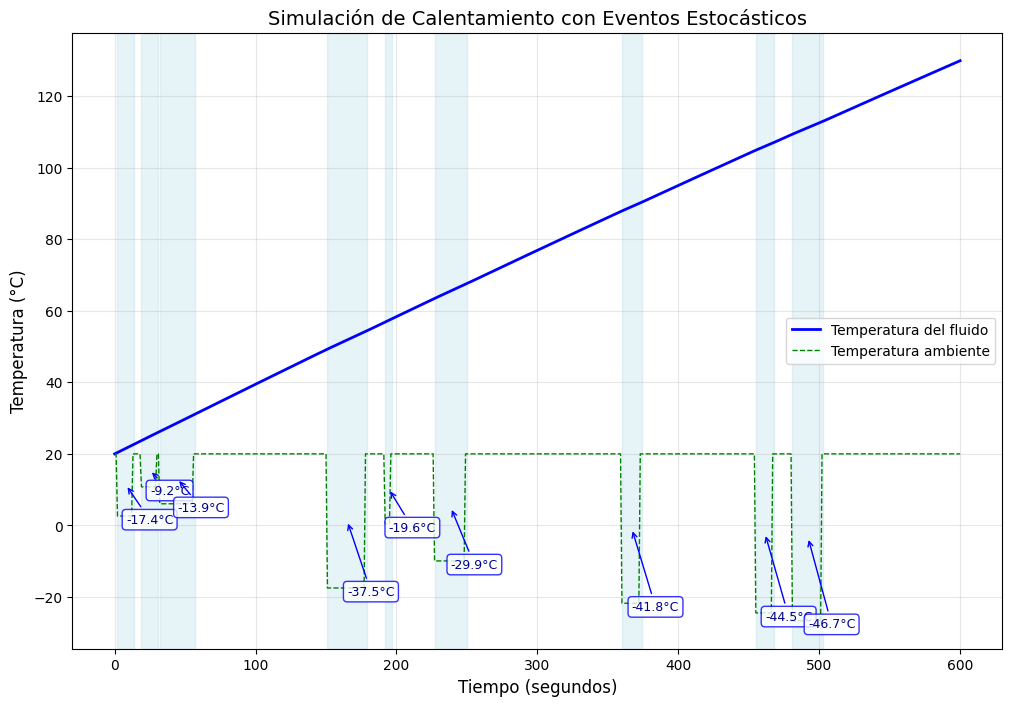

In [13]:
# Gráfico de temperaturas
plt.figure(figsize=(12, 8))

# Temperatura del fluido
plt.plot(tiempo, temperaturas_fluido, 'b-', linewidth=2, label='Temperatura del fluido')

# Temperatura ambiente
plt.plot(tiempo, temperaturas_ambiente, 'g--', linewidth=1, label='Temperatura ambiente')

# Resaltar eventos estocásticos
for evento in eventos_estocásticos:
    t_inicio = evento['tiempo_inicio']
    duracion = evento['duracion']
    t_fin = t_inicio + duracion
    
    # Sombrear la región del evento
    plt.axvspan(t_inicio, t_fin, color='lightblue', alpha=0.3)
    
    # Anotar el descenso
    plt.annotate(
        f"-{evento['descenso']:.1f}°C", 
        xy=(t_inicio + duracion/2, TEMP_AMBIENTE_BASE - evento['descenso']/2),
        xytext=(t_inicio + duracion/2, TEMP_AMBIENTE_BASE - evento['descenso'] - 2),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='blue'),
        color='darkblue',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", alpha=0.8)
    )

# Configuración del gráfico
plt.title("Simulación de Calentamiento con Eventos Estocásticos", fontsize=14)
plt.xlabel("Tiempo (segundos)", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Guardar y mostrar
plt.savefig('tp6_simulacion_estocastica.png')
plt.show()

## Simulación de Referencia Sin Eventos Estocásticos

In [14]:
# Para comparación, simulamos el mismo sistema sin eventos estocásticos
temperaturas_fluido_ref = [TEMP_INICIAL]

for i in range(1, len(tiempo)):
    t_actual = tiempo[i]
    t_anterior = tiempo[i-1]
    
    # Resolver ecuación diferencial para el siguiente paso
    temp_siguiente = odeint(
        modelo_temperatura, 
        temperaturas_fluido_ref[-1], 
        [t_anterior, t_actual], 
        args=(TEMP_AMBIENTE_BASE, MASA_AGUA, CALOR_ESPECIFICO_AGUA, POTENCIA_BASE, PERDIDA_CALOR)
    )[-1, 0]
    
    # Guardar resultados
    temperaturas_fluido_ref.append(temp_siguiente)

## Comparación Con y Sin Eventos Estocásticos

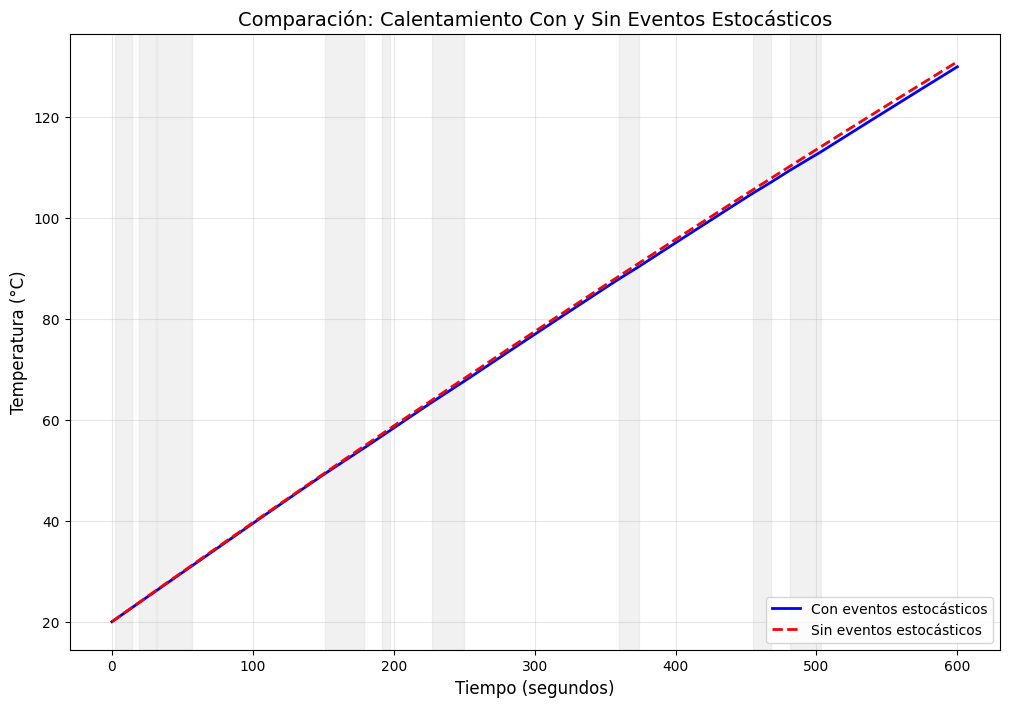

In [15]:
# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Temperatura con eventos estocásticos
plt.plot(tiempo, temperaturas_fluido, 'b-', linewidth=2, label='Con eventos estocásticos')

# Temperatura sin eventos estocásticos
plt.plot(tiempo, temperaturas_fluido_ref, 'r--', linewidth=2, label='Sin eventos estocásticos')

# Sombrear eventos estocásticos
for evento in eventos_estocásticos:
    t_inicio = evento['tiempo_inicio']
    duracion = evento['duracion']
    plt.axvspan(t_inicio, t_inicio + duracion, color='lightgray', alpha=0.3)

# Configuración del gráfico
plt.title("Comparación: Calentamiento Con y Sin Eventos Estocásticos", fontsize=14)
plt.xlabel("Tiempo (segundos)", fontsize=12)
plt.ylabel("Temperatura (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Guardar y mostrar
plt.savefig('tp6_comparacion.png')
plt.show()

## Análisis Estadístico de los Eventos

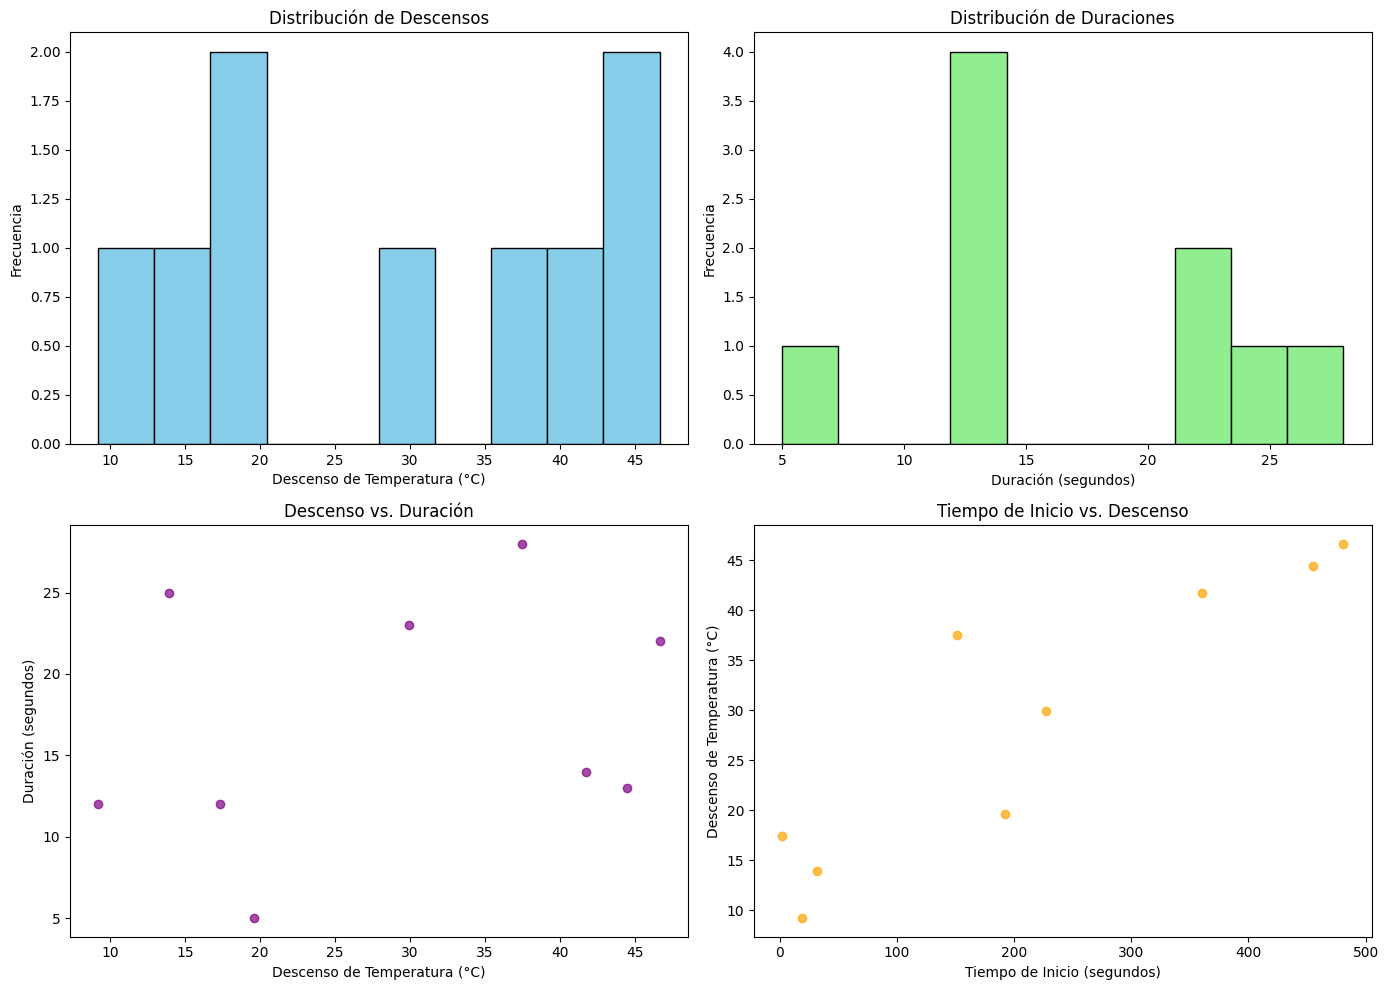


Estadísticas de los Eventos Estocásticos:
Número total de eventos: 9
Descenso promedio: 28.94°C
Duración promedio: 17.11 segundos
Intervalo promedio entre eventos: 59.88 segundos


In [16]:
# Si hay eventos, realizar análisis estadístico
if eventos_estocásticos:
    # Extraer datos de eventos
    descensos = [evento['descenso'] for evento in eventos_estocásticos]
    duraciones = [evento['duracion'] for evento in eventos_estocásticos]
    tiempos_inicio = [evento['tiempo_inicio'] for evento in eventos_estocásticos]
    
    # Crear una figura con subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histograma de descensos
    axs[0, 0].hist(descensos, bins=10, color='skyblue', edgecolor='black')
    axs[0, 0].set_title('Distribución de Descensos')
    axs[0, 0].set_xlabel('Descenso de Temperatura (°C)')
    axs[0, 0].set_ylabel('Frecuencia')
    
    # Histograma de duraciones
    axs[0, 1].hist(duraciones, bins=10, color='lightgreen', edgecolor='black')
    axs[0, 1].set_title('Distribución de Duraciones')
    axs[0, 1].set_xlabel('Duración (segundos)')
    axs[0, 1].set_ylabel('Frecuencia')
    
    # Gráfico de dispersión: descenso vs duración
    axs[1, 0].scatter(descensos, duraciones, alpha=0.7, c='purple')
    axs[1, 0].set_title('Descenso vs. Duración')
    axs[1, 0].set_xlabel('Descenso de Temperatura (°C)')
    axs[1, 0].set_ylabel('Duración (segundos)')
    
    # Gráfico de dispersión: tiempo vs descenso
    axs[1, 1].scatter(tiempos_inicio, descensos, alpha=0.7, c='orange')
    axs[1, 1].set_title('Tiempo de Inicio vs. Descenso')
    axs[1, 1].set_xlabel('Tiempo de Inicio (segundos)')
    axs[1, 1].set_ylabel('Descenso de Temperatura (°C)')
    
    plt.tight_layout()
    plt.savefig('tp6_analisis_estadistico.png')
    plt.show()
    
    # Estadísticas básicas
    print("\nEstadísticas de los Eventos Estocásticos:")
    print(f"Número total de eventos: {len(eventos_estocásticos)}")
    print(f"Descenso promedio: {np.mean(descensos):.2f}°C")
    print(f"Duración promedio: {np.mean(duraciones):.2f} segundos")
    print(f"Intervalo promedio entre eventos: {np.mean(np.diff(tiempos_inicio)):.2f} segundos")
else:
    print("\nNo se registraron eventos estocásticos durante la simulación.")

## Conclusiones

1. **Impacto de los eventos estocásticos**: Los descensos repentinos de temperatura ambiente tienen un impacto significativo en la temperatura del fluido, causando desviaciones notables respecto a la curva esperada.

2. **Recuperación del sistema**: Tras cada evento estocástico, el sistema tiende a recuperarse y volver a la trayectoria original, aunque con un retraso que depende de la magnitud y duración del evento.

3. **Variabilidad en los resultados**: La naturaleza aleatoria de los eventos introduce una variabilidad considerable en los resultados, lo que dificulta la predicción precisa del comportamiento del sistema.

4. **Implicaciones para el diseño**: Un sistema robusto debería ser capaz de manejar estas perturbaciones estocásticas, posiblemente mediante sistemas de control que ajusten la potencia en respuesta a las variaciones de temperatura.

5. **Simulación de escenarios reales**: Este modelo permite simular situaciones más realistas donde factores externos impredecibles pueden afectar el rendimiento del sistema de calentamiento.